Built grid with 34 nodes; total thickness = 6.400 mm
Simulated 600.0s with dt=0.2s (saved 601 frames)


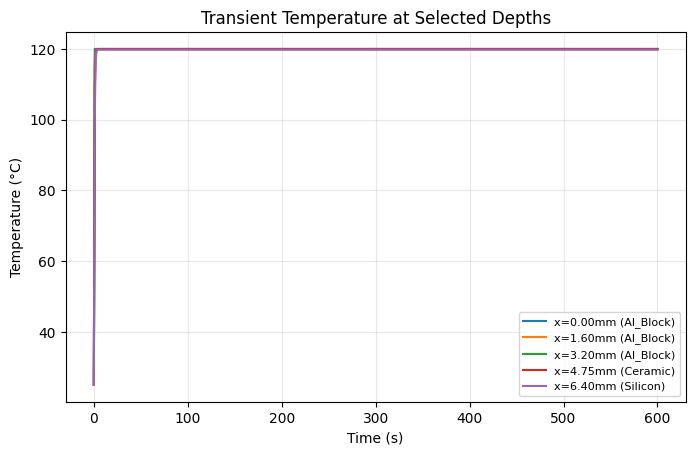

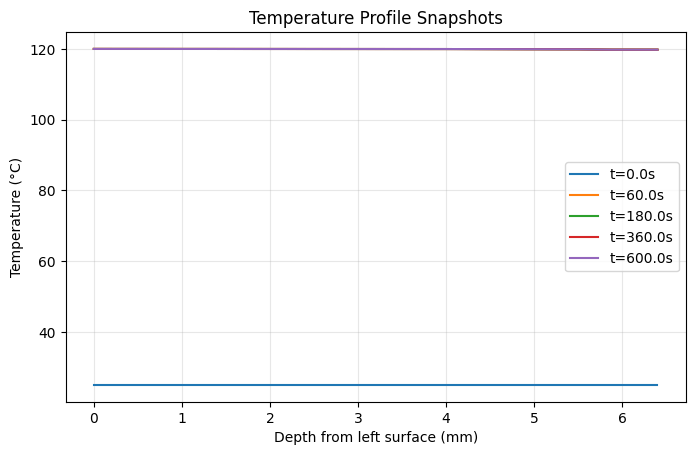


Saved outputs to: /content/project4_output
 - temperature_probes_timeseries.csv
 - temperature_profile_final.csv
 - simulation_config.json


In [1]:
# ============================================================
# Project 4 — Thermal Stack Transient Temperature Solver (1D Multilayer Physics)
# Colab-ready (CPU).
#
# What it does:
# 1) Simulates transient 1D heat conduction through a multilayer stack
#    (e.g., chuck/ceramic/TIM/wafer or package layers).
# 2) Uses an unconditionally stable implicit finite-difference solver (Backward Euler).
# 3) Supports:
#    - Multiple layers with different k, rho, cp, thickness
#    - Left boundary: prescribed temperature (Dirichlet) OR convection (Robin)
#    - Right boundary: convection to ambient (Robin)
# 4) Outputs:
#    - Temperature vs time at selected depths
#    - Optional temperature profile snapshots
#    - CSV exports for easy plotting/reporting
#
# Paste this entire cell into Google Colab and run.
# ============================================================

!pip -q install numpy pandas matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) User settings
# ----------------------------
OUT_DIR = "/content/project4_output"
os.makedirs(OUT_DIR, exist_ok=True)

# Simulation time settings
T_TOTAL_S = 600.0          # total simulation time [s]
DT_S = 0.2                 # time step [s] (implicit solver is stable; choose for resolution)
SAVE_EVERY_N = 5           # store every N steps to reduce output size

# Initial uniform temperature
T_INIT_C = 25.0

# Right-side convection boundary (always enabled)
H_RIGHT_W_M2K = 15.0       # convection coefficient [W/m^2-K]
T_AMB_RIGHT_C = 25.0       # ambient temp [C]

# Left boundary type: "dirichlet" or "convection"
LEFT_BC_TYPE = "dirichlet"  # change to "convection" if you want
T_LEFT_SETPOINT_C = 120.0   # used if LEFT_BC_TYPE = "dirichlet"
H_LEFT_W_M2K = 150.0        # used if LEFT_BC_TYPE = "convection"
T_AMB_LEFT_C = 120.0        # used if LEFT_BC_TYPE = "convection"

# Heater step: apply at t=0 (for dirichlet setpoint, that's effectively a step)
# If you want a ramp, you can replace T_left_of_t below.

# Mesh resolution per layer (smaller -> more nodes -> more accurate)
DX_TARGET_M = 2.0e-4  # 0.2 mm target cell size

# ----------------------------
# 2) Define multilayer stack (edit this)
# Units: thickness [m], k [W/mK], rho [kg/m3], cp [J/kgK]
# Example: heater block (Al) + ceramic + TIM + silicon wafer
# ----------------------------
layers = [
    {"name": "Al_Block", "thickness_m": 4.0e-3, "k": 180.0, "rho": 2700.0, "cp": 900.0},
    {"name": "Ceramic",  "thickness_m": 1.5e-3, "k": 25.0,  "rho": 3900.0, "cp": 800.0},
    {"name": "TIM",      "thickness_m": 0.2e-3, "k": 3.0,   "rho": 2500.0, "cp": 900.0},
    {"name": "Silicon",  "thickness_m": 0.7e-3, "k": 130.0, "rho": 2330.0, "cp": 700.0},
]

# ----------------------------
# 3) Build 1D grid with piecewise properties
# ----------------------------
def build_grid(layers, dx_target_m):
    x_nodes = [0.0]
    k_list, rho_list, cp_list, mat_list = [], [], [], []

    for lay in layers:
        L = lay["thickness_m"]
        n = max(2, int(np.ceil(L / dx_target_m)) + 1)  # at least 2 nodes per layer
        xs = np.linspace(x_nodes[-1], x_nodes[-1] + L, n)[1:]  # exclude first (already included)
        x_nodes.extend(xs.tolist())

        # Assign properties per node in this layer (node-based properties)
        for _ in xs:
            k_list.append(lay["k"])
            rho_list.append(lay["rho"])
            cp_list.append(lay["cp"])
            mat_list.append(lay["name"])

    x = np.array(x_nodes)
    # Properties arrays are for nodes 1..N-1 added; we need full length N
    # We'll define node properties of length N; for node 0, use first layer props
    k_node = np.empty_like(x)
    rho_node = np.empty_like(x)
    cp_node = np.empty_like(x)
    mat_node = np.empty(x.shape, dtype=object)

    # node 0 props = first layer
    k_node[0] = layers[0]["k"]
    rho_node[0] = layers[0]["rho"]
    cp_node[0] = layers[0]["cp"]
    mat_node[0] = layers[0]["name"]

    # fill remaining
    k_node[1:] = np.array(k_list)
    rho_node[1:] = np.array(rho_list)
    cp_node[1:] = np.array(cp_list)
    mat_node[1:] = np.array(mat_list, dtype=object)

    # node spacing (nonuniform possible if layers differ)
    dx = np.diff(x)  # length N-1
    return x, dx, k_node, rho_node, cp_node, mat_node

x, dx, k_node, rho_node, cp_node, mat_node = build_grid(layers, DX_TARGET_M)
N = len(x)
print(f"Built grid with {N} nodes; total thickness = {x[-1]*1e3:.3f} mm")

# ----------------------------
# 4) Boundary conditions
# ----------------------------
def T_left_of_t(t_s):
    """Left boundary temperature vs time if Dirichlet. Customize (step/ramp) here."""
    # Example: step to setpoint at t=0
    return T_LEFT_SETPOINT_C

# ----------------------------
# 5) Implicit solver assembly (Backward Euler)
# Discretization uses finite volume / variable k with harmonic interface conductivity.
# ----------------------------
def harmonic_mean(a, b, eps=1e-30):
    return 2*a*b / (a + b + eps)

def assemble_matrix_and_rhs(T_prev, dt, x, dx, k_node, rho_node, cp_node):
    """
    Build linear system A*T_new = b for 1D conduction with convection BCs.
    """
    N = len(x)
    A = np.zeros((N, N), dtype=float)
    b = np.zeros(N, dtype=float)

    # Control volume widths for node-based FV:
    # For interior nodes i, volume length ~ 0.5*(dx[i-1]+dx[i])
    # For boundaries, volume length ~ 0.5*dx[0] or 0.5*dx[-1]
    vol = np.zeros(N, dtype=float)
    vol[0] = 0.5 * dx[0]
    vol[-1] = 0.5 * dx[-1]
    vol[1:-1] = 0.5 * (dx[:-1] + dx[1:])

    # Thermal capacitance term: rho*cp*vol
    C = rho_node * cp_node * vol  # [J/m^2-K] if area=1 m^2

    # Build conduction coefficients at interfaces (i-1/2 and i+1/2)
    # We treat interface conductance G = k_eff / dx_eff, with k_eff harmonic mean.
    # Using node spacing: interface distance = dx[i-1] between node i-1 and i.
    # Conductance between i-1 and i:
    G = np.zeros(N-1, dtype=float)
    for i in range(N-1):
        k_eff = harmonic_mean(k_node[i], k_node[i+1])
        G[i] = k_eff / dx[i]  # [W/m^2-K] per unit area

    # Interior nodes
    for i in range(1, N-1):
        G_left = G[i-1]
        G_right = G[i]
        A[i, i-1] = -G_left
        A[i, i]   = C[i]/dt + (G_left + G_right)
        A[i, i+1] = -G_right
        b[i] = C[i]/dt * T_prev[i]

    # Left boundary
    if LEFT_BC_TYPE.lower() == "dirichlet":
        # Enforce T_new[0] = T_left(t)
        A[0, 0] = 1.0
        b[0] = np.nan  # set later per time step
    elif LEFT_BC_TYPE.lower() == "convection":
        # -k dT/dx = h (T_surface - T_amb)
        # FV form at node 0: conduction to node1 + convection to ambient
        G_right = G[0]
        A[0, 0] = C[0]/dt + G_right + H_LEFT_W_M2K
        A[0, 1] = -G_right
        b[0] = C[0]/dt * T_prev[0] + H_LEFT_W_M2K * T_AMB_LEFT_C
    else:
        raise ValueError("LEFT_BC_TYPE must be 'dirichlet' or 'convection'")

    # Right boundary (convection to ambient)
    # -k dT/dx = h (T_surface - T_amb)
    G_left = G[-1]
    A[-1, -2] = -G_left
    A[-1, -1] = C[-1]/dt + G_left + H_RIGHT_W_M2K
    b[-1] = C[-1]/dt * T_prev[-1] + H_RIGHT_W_M2K * T_AMB_RIGHT_C

    return A, b

# ----------------------------
# 6) Time integration loop
# ----------------------------
n_steps = int(np.ceil(T_TOTAL_S / DT_S))
time = []
T_store = []

T_prev = np.full(N, T_INIT_C, dtype=float)

# Depth probes: choose a few locations (by distance from left)
probe_depths_m = [0.0, x[-1]*0.25, x[-1]*0.5, x[-1]*0.75, x[-1]]
probe_idx = [int(np.argmin(np.abs(x - d))) for d in probe_depths_m]
probe_labels = [f"x={x[i]*1e3:.2f}mm ({mat_node[i]})" for i in probe_idx]

for step in range(n_steps + 1):
    t = step * DT_S

    # Save
    if step % SAVE_EVERY_N == 0:
        time.append(t)
        T_store.append(T_prev.copy())

    if step == n_steps:
        break

    A, b = assemble_matrix_and_rhs(T_prev, DT_S, x, dx, k_node, rho_node, cp_node)

    # Apply time-dependent Dirichlet boundary if selected
    if LEFT_BC_TYPE.lower() == "dirichlet":
        b[0] = T_left_of_t(t + DT_S)

    # Solve A*T_new = b
    T_new = np.linalg.solve(A, b)
    T_prev = T_new

time = np.array(time)
T_store = np.array(T_store)  # shape: [n_saved, N]

print(f"Simulated {T_TOTAL_S:.1f}s with dt={DT_S}s (saved {len(time)} frames)")

# ----------------------------
# 7) Plot: Temperature vs time at probe depths
# ----------------------------
plt.figure(figsize=(8, 4.8))
for i, idx in enumerate(probe_idx):
    plt.plot(time, T_store[:, idx], label=probe_labels[i])
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Transient Temperature at Selected Depths")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.show()

# ----------------------------
# 8) Plot: Temperature profiles at a few times
# ----------------------------
snap_times_s = [0, T_TOTAL_S*0.1, T_TOTAL_S*0.3, T_TOTAL_S*0.6, T_TOTAL_S]
snap_idx = [int(np.argmin(np.abs(time - ts))) for ts in snap_times_s]

plt.figure(figsize=(8, 4.8))
for si, ts in zip(snap_idx, snap_times_s):
    plt.plot(x*1e3, T_store[si], label=f"t={time[si]:.1f}s")
plt.xlabel("Depth from left surface (mm)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Profile Snapshots")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ----------------------------
# 9) Export results to CSV
# ----------------------------
# 9a) Probes timeseries
probe_df = pd.DataFrame({"time_s": time})
for label, idx in zip(probe_labels, probe_idx):
    # Make safe column names
    col = label.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    probe_df[col] = T_store[:, idx]

probe_csv = os.path.join(OUT_DIR, "temperature_probes_timeseries.csv")
probe_df.to_csv(probe_csv, index=False)

# 9b) Full field at final time
final_df = pd.DataFrame({
    "x_mm": x * 1e3,
    "material": mat_node,
    "T_final_C": T_store[-1]
})
final_csv = os.path.join(OUT_DIR, "temperature_profile_final.csv")
final_df.to_csv(final_csv, index=False)

# 9c) Save model config
config = {
    "layers": layers,
    "T_total_s": T_TOTAL_S,
    "dt_s": DT_S,
    "save_every_n": SAVE_EVERY_N,
    "T_init_C": T_INIT_C,
    "left_bc_type": LEFT_BC_TYPE,
    "T_left_setpoint_C": T_LEFT_SETPOINT_C,
    "h_left_W_m2K": H_LEFT_W_M2K,
    "T_amb_left_C": T_AMB_LEFT_C,
    "h_right_W_m2K": H_RIGHT_W_M2K,
    "T_amb_right_C": T_AMB_RIGHT_C,
    "dx_target_m": DX_TARGET_M,
}
config_path = os.path.join(OUT_DIR, "simulation_config.json")
import json
with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

print("\nSaved outputs to:", OUT_DIR)
print(" - temperature_probes_timeseries.csv")
print(" - temperature_profile_final.csv")
print(" - simulation_config.json")

# In Colab: left sidebar → Files → project4_output → download
